# 🎓 Projet : Prédiction de la Performance des Étudiants Marocains
**Équipe :** Squad 2 (Model Building)
**Date :** 10 Février 2026

## 🎯 Objectif
Développer et comparer plusieurs modèles de Machine Learning (Régression) pour prédire la note annuelle (`moyenne_annuelle`) en fonction des indicateurs académiques et socio-économiques.

## 📋 Sommaire
1. Chargement et exploration des données
2. Prétraitement (feature engineering, scaling, encoding, split)
3. Modélisation (6 modèles : LinearRegression, Ridge, Lasso, RandomForest, XGBoost, MLP)
4. Comparaison des performances (R², RMSE, MAE)
5. Validation croisée (5-Fold)
6. Optimisation des hyperparamètres (RandomizedSearchCV)
7. Analyse des résidus et importance des features
8. Interprétabilité (SHAP Values)
9. Courbes d'apprentissage (Learning Curves)
10. Sauvegarde du meilleur modèle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold,
    RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import des modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# 1. Charger les données
df = pd.read_csv("../dataset/Morocco_Student_Data_Cleaned.csv")
print(f"✅ Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"\n📋 Aperçu des premières lignes :")
display(df.head())
print(f"\n📊 Statistiques descriptives :")
display(df.describe())

✅ Données chargées : 10000 lignes, 268 colonnes

📋 Aperçu des premières lignes :


,id_etudiant,prenom,nom,nom_complet,sexe,date_naissance,age,code_massar,region,province,...,autre_langue,locuteur_amazigh,maitrise_darija,francais_maison,performance_cible,niveau_risque,intervention_necessaire,date_collecte,id_collecteur,statut_verification
0,STU00001,Soumia,Chraibi,Soumia Chraibi,F,2007-05-05,19,G548679848,Fes-Meknes,El Hajeb,...,Non,Natif,Rarement,Tres Eleve,0.54,Moyen,Oui,2026-01-15,COL008,Verifie
1,STU00002,Mehdi,Tazi,Mehdi Tazi,M,2009-10-12,17,G478451439,Souss-Massa,Inezgane,...,Oui,Natif,Parfois,Eleve,0.08,Eleve,Oui,2026-01-15,COL005,Verifie
2,STU00003,Bilal,Lahbabi,Bilal Lahbabi,M,2008-08-08,18,G727518594,Casablanca-Settat,Berrechid,...,Oui,Natif,Souvent,Tres Eleve,0.47,Eleve,Oui,2026-01-15,COL001,Verifie
3,STU00004,Hakim,Chraibi,Hakim Chraibi,M,2009-10-05,17,G868905524,Tanger-Tetouan-Al Hoceima,Larache,...,Non,Natif,Parfois,Eleve,0.55,Moyen,Oui,2026-01-15,COL008,Verifie
4,STU00005,Ayoub,Lahbabi,Ayoub Lahbabi,M,2007-05-27,19,G809425460,Casablanca-Settat,El Jadida,...,Non,Natif,Souvent,Eleve,0.15,Eleve,Oui,2026-01-15,COL004,Verifie



📊 Statistiques descriptives :


,age,code_postal,telephone,annee_inscription,revenu_mensuel_pere,revenu_mensuel_mere,telephone_tuteur,revenu_familial,nombre_freres_soeurs,rang_fratrie,...,tentatives_bac_precedentes,notes_examens_blancs,taux_assiduite,taux_ponctualite,taux_remise_devoirs,niveau_litteratie_numerique,competitions_scolaires,prix_recus,experience_stage,performance_cible
count,10000.000000,10000.000000,1.000000e+04,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.00000,...,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,18.090400,52052.000000,6.551848e+08,2024.0,8859.259300,5718.875112,6.551801e+08,13889.203450,2.498700,2.29430,...,0.0,71.731200,89.219700,91.293700,82.897400,44.004200,2.891100,5.795900,58.58170,0.411558
std,0.789614,24579.420473,2.597032e+07,0.0,5472.455318,4226.069460,2.598213e+07,6960.873145,1.396063,1.21146,...,0.0,15.262432,6.541216,5.387072,10.152477,16.720046,1.959955,3.682798,34.29741,0.185743
min,17.000000,10000.000000,6.100040e+08,2024.0,0.000000,0.000000,6.100040e+08,0.000000,0.000000,1.00000,...,0.0,45.000000,78.000000,82.000000,65.000000,15.000000,0.000000,0.000000,0.00000,0.080000
25%,17.000000,31000.000000,6.327122e+08,2024.0,4613.750000,2643.000000,6.327300e+08,8567.750000,2.000000,1.00000,...,0.0,59.000000,84.000000,87.000000,74.000000,30.000000,1.000000,3.000000,29.00000,0.270000
50%,18.000000,52000.000000,6.552471e+08,2024.0,7337.000000,4746.000000,6.553210e+08,12773.500000,2.000000,2.00000,...,0.0,72.000000,89.000000,91.000000,83.000000,44.000000,3.000000,6.000000,58.00000,0.410000
75%,19.000000,73000.000000,6.776673e+08,2024.0,11850.250000,8229.250000,6.777016e+08,18292.750000,3.000000,3.00000,...,0.0,85.000000,95.000000,96.000000,92.000000,57.000000,5.000000,9.000000,88.00000,0.550000
max,19.000000,95000.000000,6.999856e+08,2024.0,22705.000000,16608.625000,6.999853e+08,32880.250000,6.000000,7.00000,...,0.0,98.000000,100.000000,100.000000,100.000000,75.000000,6.000000,12.000000,120.00000,0.990000


## 🛠 1. Prétraitement des Données (Preprocessing)

### Sélection des Features
- **[Attention] Data Leakage** : `moyenne_s1`, `moyenne_s2`, toutes les notes par matiÃ¨re (`*_s1`, `*_s2`, `*_annuel`), `performance_cible`, `rang_*` sont **exclues** car elles sont des composantes directes ou dérivées de `moyenne_annuelle`.
- **Features retenues** : Variables socio-économiques, comportementales, habitudes d'étude, et caractéristiques démographiques — des variables "indépendantes" disponibles **avant** les résultats scolaires.

### Transformation
- *StandardScaler* pour les variables numériques
- *OneHotEncoder* pour les variables catégorielles

### Split : 80% Entraînement / 20% Test

In [ ]:
# 2. Définir la Target (Cible)
y = df["moyenne_annuelle"]

# 3. Définir les Features (Variables)
# SCÉNARIO 1 : Début d'année (Sans les notes S1/S2) - Pour éviter le Data Leakage
features_socio = [
    # --- Variables numériques ---
    "heures_etude_jour", "heures_etude_weekend",
    "absences_totales", "age", "distance_ecole_km",
    "revenu_familial", "nombre_freres_soeurs", "nombre_membres_famille",
    "heures_soutien_semaine", "heures_sommeil_semaine",
    "activite_physique_heures_semaine", "temps_ecran_heures_jour",
    "taux_assiduite", "taux_ponctualite", "taux_remise_devoirs",
    "annees_redoublement", "retards",
    
    # --- Variables catégorielles ---
    "sexe", "zone", "soutien_familial",
    "niveau", "filiere", "region",
    "niveau_education_pere", "niveau_education_mere",
    "statut_parental", "cours_particuliers",
    "niveau_motivation", "participation_classe", "attention_cours",
    "implication_parents", "confiance_en_soi",
    "internet", "chambre_personnelle", "ordinateur_portable",
]

# SCÉNARIO 2 : Mi-année (Avec les notes S1) - Pour la performance
# On ajoute la moyenne du semestre 1
features_academique = features_socio + ["moyenne_s1"]

# Par défaut pour le début, on utilise le scénario socio-économique
# Vérification que les colonnes existent
features_socio = [c for c in features_socio if c in df.columns]
features_academique = [c for c in features_academique if c in df.columns]

X = df[features_socio]

print(f"📌 Nombre de features (Scénario 1 - Socio): {len(features_socio)}")
if "moyenne_s1" in df.columns:
    print(f"📌 Nombre de features (Scénario 2 - Académique): {len(features_academique)}")
else:
    print("[Attention] 'moyenne_s1' non trouvÃ©e, ScÃ©nario 2 indisponible")

# 4. Séparer colonnes numériques et catégorielles (pour Scénario 1)
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures Numériques ({len(num_features)}) : {num_features}")
print(f"Features Catégorielles ({len(cat_features)}) : {cat_features}")

# Vérification : colonnes catégorielles avec 1 seule valeur (inutiles)
cols_to_remove = []
for col in cat_features:
    n_uniq = X[col].nunique()
    if n_uniq <= 1:
        print(f"[Attention] '{col}' n'a que {n_uniq} valeur(s) unique(s) -> supprimÃ©e")
        cols_to_remove.append(col)

for col in cols_to_remove:
    features_socio.remove(col)
    if col in features_academique: features_academique.remove(col)
    cat_features.remove(col)

X = df[features_socio]

# 5. Aperçu des corrélations numériques avec la cible
print(f"\n📊 Corrélation des features numériques avec moyenne_annuelle :")
corr_with_target = df[num_features + ['moyenne_annuelle']].corr()['moyenne_annuelle'].drop('moyenne_annuelle')
corr_with_target = corr_with_target.sort_values(ascending=False)
for feat, corr in corr_with_target.items():
    print(f"   {feat:<40} r = {corr:+.4f}")

# 6. Preprocessor (Uniquement pour Scénario 1 initialement)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

# 7. Split Train/Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n✅ Split effectué (Scénario 1) : Train = {X_train.shape[0]}, Test = {X_test.shape[0]}")

📌 Nombre de features (Scénario 1 - Socio): 35
📌 Nombre de features (Scénario 2 - Académique): 36

Features Numériques (17) : ['heures_etude_jour', 'heures_etude_weekend', 'absences_totales', 'age', 'distance_ecole_km', 'revenu_familial', 'nombre_freres_soeurs', 'nombre_membres_famille', 'heures_soutien_semaine', 'heures_sommeil_semaine', 'activite_physique_heures_semaine', 'temps_ecran_heures_jour', 'taux_assiduite', 'taux_ponctualite', 'taux_remise_devoirs', 'annees_redoublement', 'retards']
Features Catégorielles (18) : ['sexe', 'zone', 'soutien_familial', 'niveau', 'filiere', 'region', 'niveau_education_pere', 'niveau_education_mere', 'statut_parental', 'cours_particuliers', 'niveau_motivation', 'participation_classe', 'attention_cours', 'implication_parents', 'confiance_en_soi', 'internet', 'chambre_personnelle', 'ordinateur_portable']

📊 Corrélation des features numériques avec moyenne_annuelle :
   revenu_familial                          r = +0.3704
   heures_soutien_semaine    

## 🤖 2. Modélisation (Model Building)

Nous testons **6 algorithmes** pour comparer leurs performances :

| # | Modèle | Pourquoi ? |
|---|--------|-----------|
| 1 | **Régression Linéaire** | Baseline simple |
| 2 | **Ridge (L2)** | Régularisation L2 pour limiter le surapprentissage |
| 3 | **Lasso (L1)** | Régularisation L1 + sélection automatique de features |
| 4 | **Random Forest** | Capture les non-linéarités / interactions |
| 5 | **XGBoost** | État de l'art pour les données tabulaires |
| 6 | **MLP (Deep Learning)** | Réseau de neurones pour les relations complexes |

**Métriques d'évaluation :**
- **RMSE** : Erreur moyenne en points (plus bas = mieux)
- **MAE** : Erreur absolue moyenne (plus interprétable)
- **R²** : Variance expliquée (plus proche de 1 = mieux)

**Validation :**
- Train/Test Split (80/20) + Cross-Validation (5-Fold)

In [3]:
# --- DÉFINITION DES 6 MODÈLES (Scénario 1 - Optimisé pour éviter Overfitting) ---

models = {
    "Régression Linéaire": LinearRegression(),

    "Ridge (L2)": Ridge(alpha=10.0),  # Augmentation alpha pour réduire variance

    "Lasso (L1)": Lasso(alpha=0.1, max_iter=5000), # Augmentation alpha

    "Random Forest": RandomForestRegressor(
        n_estimators=100,      # Réduit pour éviter overfitting
        max_depth=6,           # Fortement réduit (était 15) pour limiter complexité
        min_samples_leaf=10,   # Augmenté pour lisser les prédictions
        max_features='sqrt',   # Force à ne pas utiliser toutes les features
        random_state=42, n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,    # Réduit pour apprentissage plus lent/robuste
        max_depth=3,           # Réduit (était 6) pour modèle plus simple
        reg_alpha=1.0,         # Ajout régularisation L1
        reg_lambda=1.0,        # Ajout régularisation L2
        subsample=0.7,         # Utilise seulement 70% des données par arbre
        colsample_bytree=0.7,  # Utilise seulement 70% des features par arbre
        random_state=42, n_jobs=-1
    ),

    "Deep Learning (MLP)": MLPRegressor(
        hidden_layer_sizes=(64, 32), # Réduit complexité réseau
        alpha=0.01,                # Régularisation L2 augmentée
        max_iter=1000,
        random_state=42, early_stopping=True, validation_fraction=0.1
    )
}

# --- ENTRAÎNEMENT ET ÉVALUATION ---
results = []
trained_pipelines = {}

print("🚀 Début de l'entraînement des 6 modèles (Scénario 1 : Début d'année)...\n")

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Métriques Test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Métriques Train (pour détecter overfitting)
    r2_train = r2_score(y_train, y_pred_train)

    results.append([name, rmse, mae, r2_test, r2_train])
    trained_pipelines[name] = pipeline

    overfit_flag = " [Attention] Overfitting" if (r2_train - r2_test) > 0.10 else ""
    print(f"✅ {name:<25} R²_test: {r2_test:.4f} | R²_train: {r2_train:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}{overfit_flag}")

🚀 Début de l'entraînement des 6 modèles (Scénario 1 : Début d'année)...

✅ Régression Linéaire       R²_test: 0.1769 | R²_train: 0.1808 | RMSE: 2.0162 | MAE: 1.7147
✅ Ridge (L2)                R²_test: 0.1777 | R²_train: 0.1806 | RMSE: 2.0152 | MAE: 1.7137
✅ Lasso (L1)                R²_test: 0.1430 | R²_train: 0.1327 | RMSE: 2.0573 | MAE: 1.7408
✅ Random Forest             R²_test: 0.1478 | R²_train: 0.1756 | RMSE: 2.0515 | MAE: 1.7384
✅ XGBoost                   R²_test: 0.1773 | R²_train: 0.2109 | RMSE: 2.0157 | MAE: 1.7139
✅ Deep Learning (MLP)       R²_test: 0.1585 | R²_train: 0.2118 | RMSE: 2.0386 | MAE: 1.7351



📊 TABLEAU COMPARATIF FINAL :


,Modèle,RMSE,MAE,R² Test,R² Train
0,Ridge (L2),2.015230,1.713711,0.177682,0.180594
1,XGBoost,2.015657,1.713893,0.177333,0.210857
2,Régression Linéaire,2.016245,1.714727,0.176853,0.180787
3,Deep Learning (MLP),2.038601,1.735102,0.158498,0.211847
4,Random Forest,2.051541,1.738447,0.147782,0.175618
5,Lasso (L1),2.057273,1.740844,0.143013,0.132740


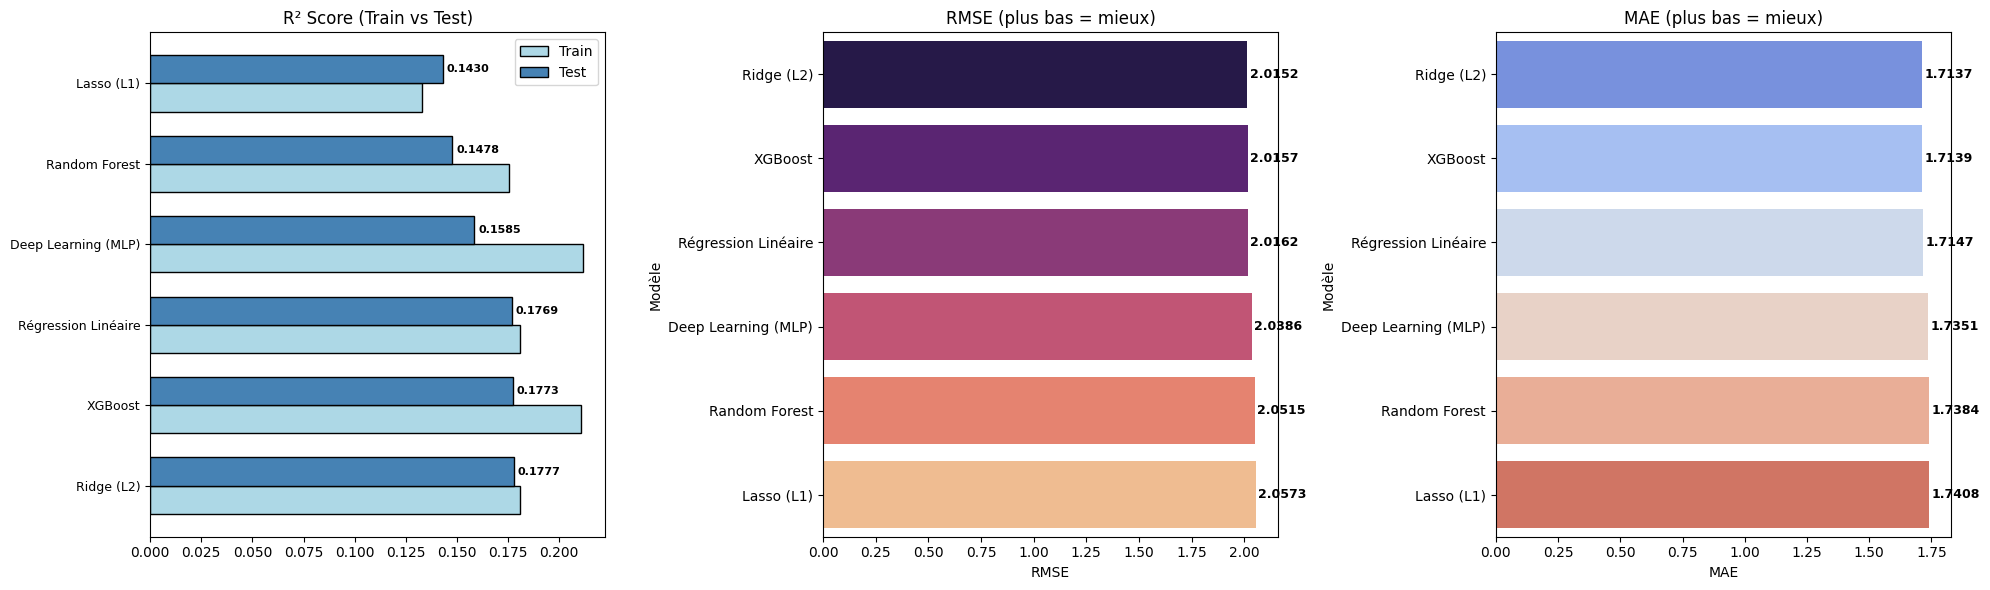

In [4]:
# --- AFFICHAGE DES RÉSULTATS ---
results_df = pd.DataFrame(results, columns=["Modèle", "RMSE", "MAE", "R² Test", "R² Train"])
results_df = results_df.sort_values(by="R² Test", ascending=False).reset_index(drop=True)

print("\n📊 TABLEAU COMPARATIF FINAL :")
display(results_df)

# Graphiques de comparaison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# R² Score (Train vs Test)
x = np.arange(len(results_df))
width = 0.35
axes[0].barh(x - width/2, results_df["R² Train"], width, label="Train", color="lightblue", edgecolor="black")
axes[0].barh(x + width/2, results_df["R² Test"], width, label="Test", color="steelblue", edgecolor="black")
axes[0].set_yticks(x)
axes[0].set_yticklabels(results_df["Modèle"], fontsize=9)
axes[0].set_title("R² Score (Train vs Test)")
axes[0].legend()
for i, (train_v, test_v) in enumerate(zip(results_df["R² Train"], results_df["R² Test"])):
    axes[0].text(test_v + 0.002, i + width/2, f'{test_v:.4f}', va='center', fontsize=8, fontweight='bold')

# RMSE
sns.barplot(x="RMSE", y="Modèle", hue="Modèle", data=results_df, palette="magma", legend=False, ax=axes[1])
axes[1].set_title("RMSE (plus bas = mieux)")
for i, v in enumerate(results_df["RMSE"]):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

# MAE
sns.barplot(x="MAE", y="Modèle", hue="Modèle", data=results_df, palette="coolwarm", legend=False, ax=axes[2])
axes[2].set_title("MAE (plus bas = mieux)")
for i, v in enumerate(results_df["MAE"]):
    axes[2].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 🔄 3. Validation Croisée (Cross-Validation 5-Fold)
Pour vérifier la **stabilité** des modèles, nous utilisons une validation croisée à 5 plis.
Cela permet de s'assurer que les résultats ne dépendent pas d'un seul split de données.

Un **écart-type R² élevé** indique un modèle instable selon le découpage des données.

In [5]:
# --- CROSS-VALIDATION 5-FOLD ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("🔄 Validation Croisée (5-Fold) en cours...\n")

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores_r2 = cross_val_score(pipe, X, y, cv=kf, scoring='r2', n_jobs=-1)
    scores_rmse = cross_val_score(pipe, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    cv_results.append([
        name,
        scores_r2.mean(), scores_r2.std(),
        -scores_rmse.mean(), scores_rmse.std()
    ])
    
    stability = "Stable" if scores_r2.std() < 0.02 else "Variable"
    print(f"{name:<25} R² = {scores_r2.mean():.4f} ± {scores_r2.std():.4f}  [{stability}]")

cv_df = pd.DataFrame(cv_results, columns=["Modèle", "R² Moyen", "R² Écart-type", "RMSE Moyen", "RMSE Écart-type"])
cv_df = cv_df.sort_values(by="R² Moyen", ascending=False).reset_index(drop=True)

print("\n📊 RÉSULTATS CROSS-VALIDATION :")
display(cv_df)

🔄 Validation Croisée (5-Fold) en cours...

Régression Linéaire       R² = 0.1671 ± 0.0184  [Stable]
Ridge (L2)                R² = 0.1670 ± 0.0188  [Stable]
Lasso (L1)                R² = 0.1341 ± 0.0151  [Stable]
Random Forest             R² = 0.1430 ± 0.0094  [Stable]
XGBoost                   R² = 0.1719 ± 0.0183  [Stable]
Deep Learning (MLP)       R² = 0.1539 ± 0.0184  [Stable]

📊 RÉSULTATS CROSS-VALIDATION :


,Modèle,R² Moyen,R² Écart-type,RMSE Moyen,RMSE Écart-type
0,XGBoost,0.171919,0.018308,2.035342,0.013507
1,Régression Linéaire,0.167069,0.018359,2.041300,0.014312
2,Ridge (L2),0.167026,0.018773,2.041345,0.014693
3,Deep Learning (MLP),0.153915,0.018433,2.057350,0.012693
4,Random Forest,0.143049,0.009389,2.070760,0.020139
5,Lasso (L1),0.134146,0.015149,2.081352,0.015518


## 4. Optimisation des Hyperparamètres (RandomizedSearchCV)

On optimise les **2 meilleurs modèles** (Random Forest et XGBoost) avec une recherche aléatoire sur une grille d'hyperparamètres, évaluation par cross-validation 3-Fold.

In [6]:
# --- OPTIMISATION DES HYPERPARAMÈTRES ---

from scipy.stats import randint, uniform

param_grids = {
    "Random Forest": {
        'model__n_estimators': randint(100, 500),
        'model__max_depth': [5, 10, 15, 20, 25, None],
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
        'model__max_features': ['sqrt', 'log2', None],
    },
    "XGBoost": {
        'model__n_estimators': randint(100, 500),
        'model__max_depth': randint(3, 12),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__subsample': uniform(0.6, 0.4),
        'model__colsample_bytree': uniform(0.6, 0.4),
        'model__min_child_weight': randint(1, 10),
        'model__reg_alpha': uniform(0, 1),
        'model__reg_lambda': uniform(0.5, 2),
    }
}

tuned_pipelines = {}

for name, params in param_grids.items():
    print(f"\n🔧 Optimisation de {name}...")
    
    base_model = models[name]
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', base_model)
    ])
    
    search = RandomizedSearchCV(
        pipe, params, n_iter=50, cv=3, scoring='r2',
        random_state=42, n_jobs=-1, verbose=0
    )
    search.fit(X_train, y_train)
    
    y_pred_tuned = search.predict(X_test)
    r2_tuned = r2_score(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    
    # R² avant optimisation
    r2_before = results_df.loc[results_df['Modèle'] == name, 'R² Test'].values[0]
    improvement = r2_tuned - r2_before
    
    print(f"   R² avant : {r2_before:.4f} → R² après : {r2_tuned:.4f} (Δ = {improvement:+.4f})")
    print(f"   RMSE : {rmse_tuned:.4f} | MAE : {mae_tuned:.4f}")
    print(f"   Meilleurs paramètres :")
    for k, v in search.best_params_.items():
        print(f"     {k.replace('model__', '')}: {v}")
    
    tuned_pipelines[name] = search.best_estimator_
    trained_pipelines[f"{name} (Tuned)"] = search.best_estimator_


🔧 Optimisation de Random Forest...
   R² avant : 0.1478 → R² après : 0.1806 (Δ = +0.0328)
   RMSE : 2.0117 | MAE : 1.7110
   Meilleurs paramètres :
     max_depth: 20
     max_features: sqrt
     min_samples_leaf: 1
     min_samples_split: 13
     n_estimators: 413

🔧 Optimisation de XGBoost...
   R² avant : 0.1773 → R² après : 0.1827 (Δ = +0.0054)
   RMSE : 2.0090 | MAE : 1.7103
   Meilleurs paramètres :
     colsample_bytree: 0.6777095814048169
     learning_rate: 0.031282275099978295
     max_depth: 5
     min_child_weight: 7
     n_estimators: 242
     reg_alpha: 0.375582952639944
     reg_lambda: 0.687963879681738
     subsample: 0.8313120563984696


Meilleur modèle : XGBoost (Tuned) (RÂ² = 0.1827)



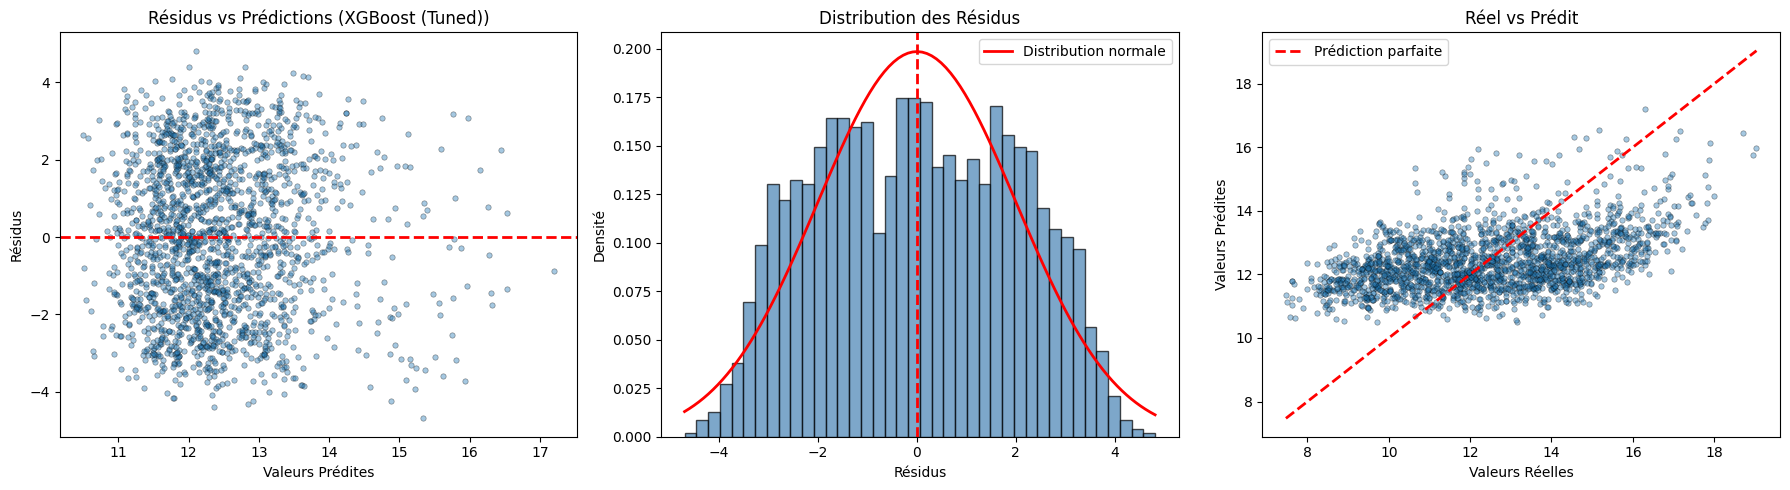

Test de normalité (Shapiro-Wilk) : p-value = 0.0000 -> Résidus non normaux


In [7]:
# --- ANALYSE DES RÉSIDUS (meilleur modèle tuné ou non-tuné) ---

# Choisir le meilleur modèle global
all_models_r2 = {}
for name, pipe in trained_pipelines.items():
    y_pred = pipe.predict(X_test)
    all_models_r2[name] = r2_score(y_test, y_pred)

best_name = max(all_models_r2, key=all_models_r2.get)
best_pipeline = trained_pipelines[best_name]
y_pred_best = best_pipeline.predict(X_test)
residuals = y_test - y_pred_best

print(f"Meilleur modèle : {best_name} (RÂ² = {all_models_r2[best_name]:.4f})\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Résidus vs Prédictions
axes[0].scatter(y_pred_best, residuals, alpha=0.4, edgecolors='k', linewidth=0.5, s=15)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valeurs Prédites')
axes[0].set_ylabel('Résidus')
axes[0].set_title(f'Résidus vs Prédictions ({best_name})')

# 2. Distribution des résidus
axes[1].hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='steelblue', density=True)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
# Superposer une courbe normale
from scipy import stats
x_range = np.linspace(residuals.min(), residuals.max(), 100)
axes[1].plot(x_range, stats.norm.pdf(x_range, residuals.mean(), residuals.std()), 'r-', linewidth=2, label='Distribution normale')
axes[1].set_xlabel('Résidus')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des Résidus')
axes[1].legend()

# 3. Valeurs réelles vs Prédites
axes[2].scatter(y_test, y_pred_best, alpha=0.4, edgecolors='k', linewidth=0.5, s=15)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')
axes[2].set_xlabel('Valeurs Réelles')
axes[2].set_ylabel('Valeurs Prédites')
axes[2].set_title('Réel vs Prédit')
axes[2].legend()

plt.tight_layout()
plt.show()

# Test de normalité des résidus
_, p_value = stats.shapiro(residuals.sample(min(500, len(residuals)), random_state=42))
print(f"Test de normalité (Shapiro-Wilk) : p-value = {p_value:.4f}", end="")
print(" -> Résidus normaux" if p_value > 0.05 else " -> Résidus non normaux")

## 📊 5. Importance des Features (Feature Importance)
- **Feature Importance** des modèles à base d'arbres (Random Forest, XGBoost)
- Identification des variables les plus influentes pour la prédiction

📊 Nombre total de features (après encoding) : 91



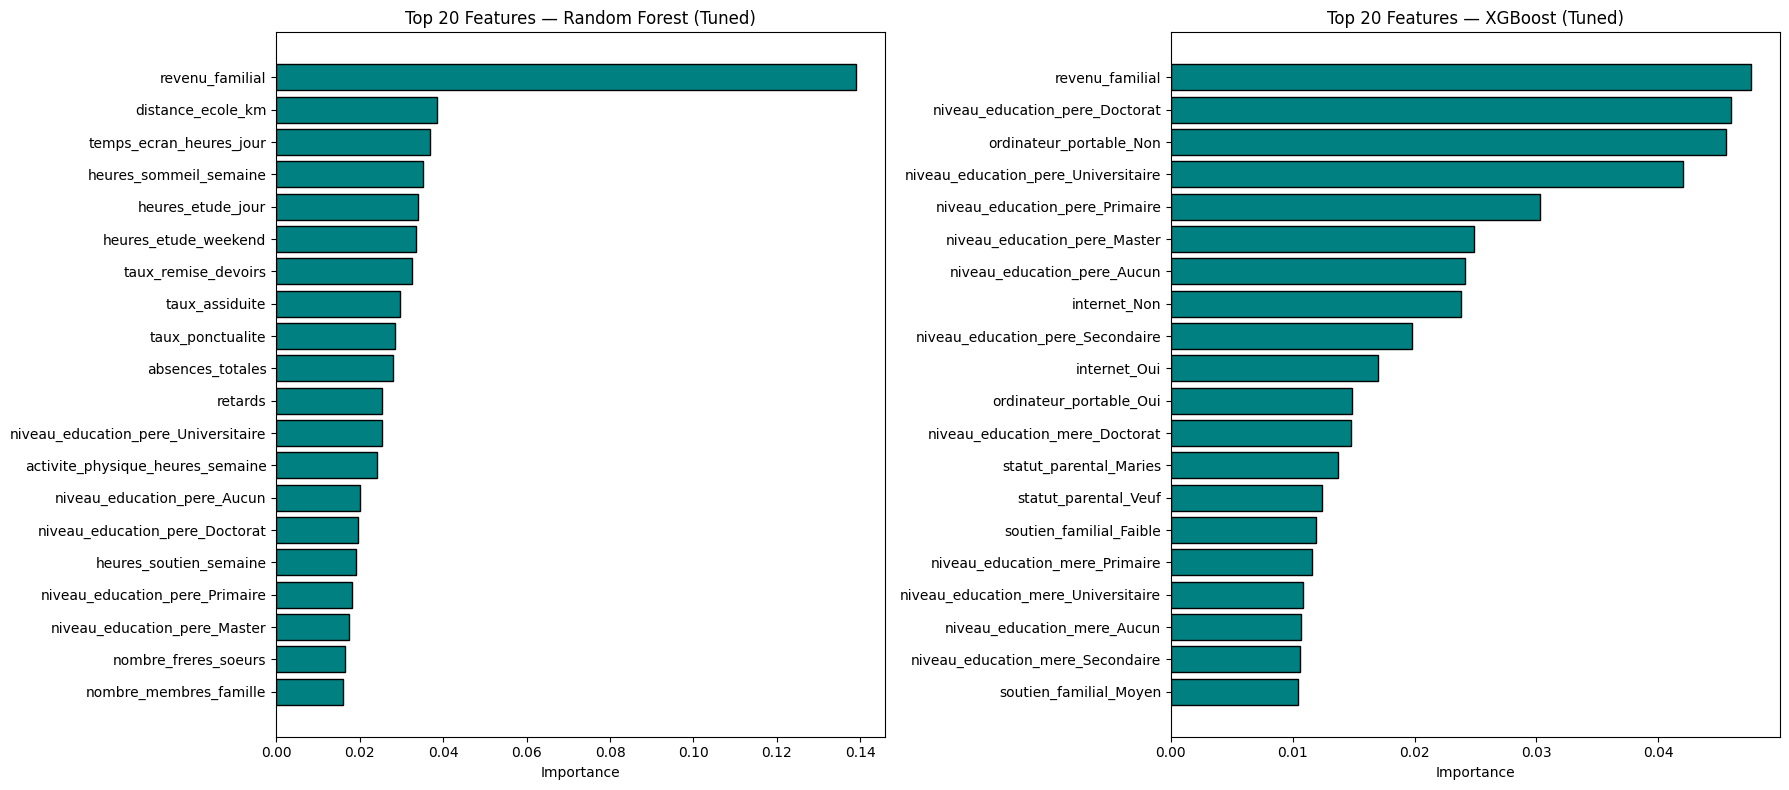


Top 10 Features (XGBoost (Tuned)) :
   revenu_familial                          0.0476
   niveau_education_pere_Doctorat           0.0459
   ordinateur_portable_Non                  0.0456
   niveau_education_pere_Universitaire      0.0421
   niveau_education_pere_Primaire           0.0303
   niveau_education_pere_Master             0.0249
   niveau_education_pere_Aucun              0.0242
   internet_Non                             0.0238
   niveau_education_pere_Secondaire         0.0198
   internet_Oui                             0.0170


In [8]:
# --- FEATURE IMPORTANCE (Random Forest & XGBoost) ---

# Récupérer les noms des features après transformation
feature_names_transformed = num_features.copy()
if cat_features:
    # Utiliser le meilleur pipeline qui contient un modèle à arbres
    for model_name_check in ["Random Forest (Tuned)", "XGBoost (Tuned)", "Random Forest", "XGBoost"]:
        if model_name_check in trained_pipelines:
            ohe = trained_pipelines[model_name_check].named_steps['preprocessor'].named_transformers_['cat']
            cat_feature_names = ohe.get_feature_names_out(cat_features).tolist()
            feature_names_transformed += cat_feature_names
            break

print(f"📊 Nombre total de features (après encoding) : {len(feature_names_transformed)}\n")

# Plot pour les modèles tunés ou originaux
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_idx = 0

for model_label in ["Random Forest", "XGBoost"]:
    # Préférer la version tunée
    tuned_label = f"{model_label} (Tuned)"
    name_to_use = tuned_label if tuned_label in trained_pipelines else model_label
    
    if name_to_use in trained_pipelines:
        pipe = trained_pipelines[name_to_use]
        importances = pipe.named_steps['model'].feature_importances_
        
        imp_df = pd.DataFrame({
            'Feature': feature_names_transformed,
            'Importance': importances
        }).sort_values(by='Importance', ascending=True)
        
        # Top 20 features
        imp_top = imp_df.tail(20)
        
        axes[plot_idx].barh(imp_top['Feature'], imp_top['Importance'], color='teal', edgecolor='black')
        axes[plot_idx].set_title(f'Top 20 Features — {name_to_use}', fontsize=12)
        axes[plot_idx].set_xlabel('Importance')
        plot_idx += 1

plt.tight_layout()
plt.show()

# Afficher les 10 features les plus importantes du meilleur modèle
print(f"\nTop 10 Features ({name_to_use}) :")
for _, row in imp_df.tail(10).iloc[::-1].iterrows():
    print(f"   {row['Feature']:<40} {row['Importance']:.4f}")

## 6. Interprétabilité avec SHAP Values
SHAP (SHapley Additive exPlanations) permet de comprendre **pourquoi** le modèle fait chaque prédiction. Chaque feature reçoit un score SHAP indiquant sa contribution (positive ou négative) à la prédiction.

📊 SHAP Summary Plot — XGBoost (Tuned)



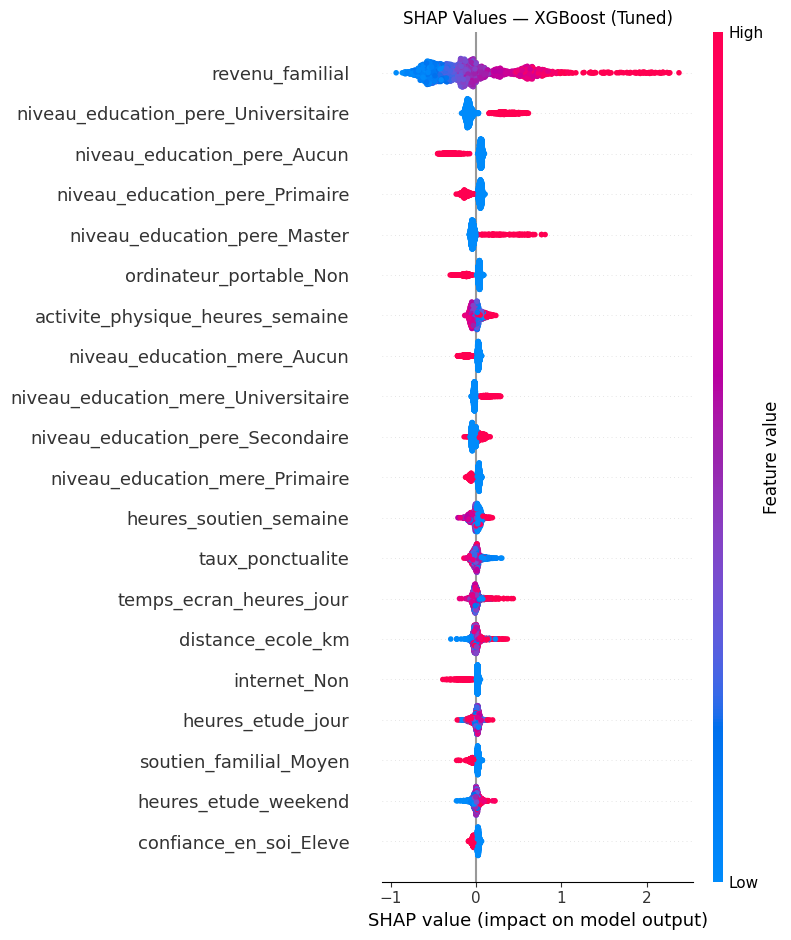

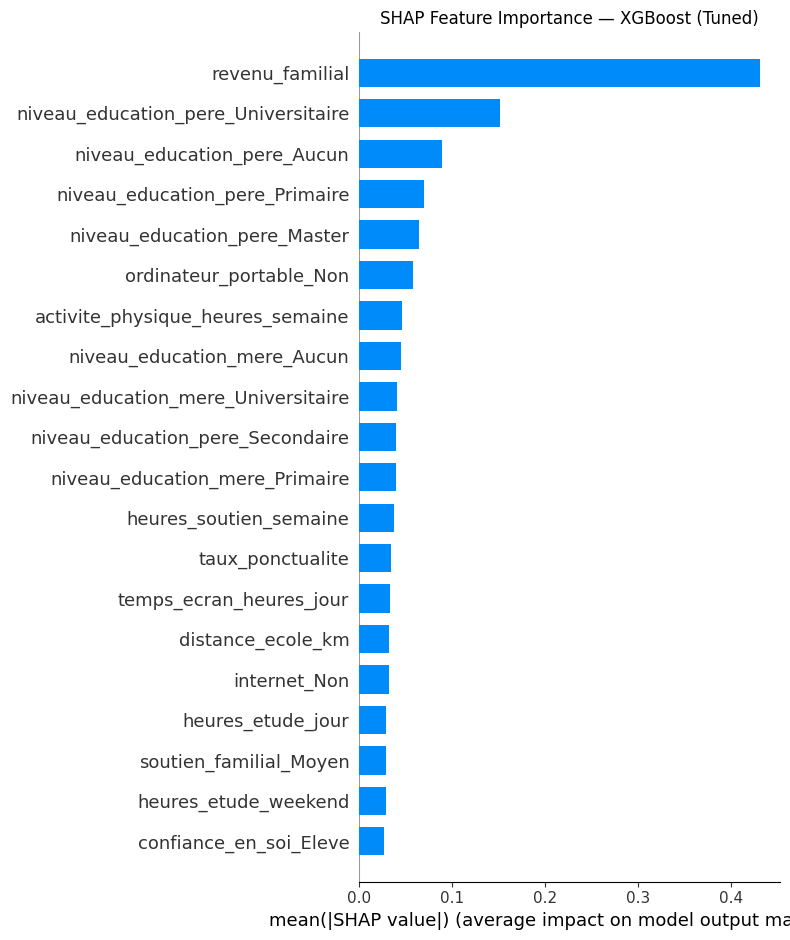

In [9]:
# --- SHAP Values ---
try:
    import shap
    
    # Utiliser le meilleur modèle XGBoost (tuné ou original)
    shap_model_name = "XGBoost (Tuned)" if "XGBoost (Tuned)" in trained_pipelines else "XGBoost"
    shap_pipeline = trained_pipelines[shap_model_name]
    
    # Transformer les données
    X_test_transformed = shap_pipeline.named_steps['preprocessor'].transform(X_test)
    X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)
    
    # Calculer les SHAP values
    explainer = shap.TreeExplainer(shap_pipeline.named_steps['model'])
    shap_values = explainer.shap_values(X_test_df)
    
    # 1. Summary Plot (Bee swarm)
    print(f"📊 SHAP Summary Plot — {shap_model_name}\n")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_df, max_display=20, show=False)
    plt.title(f"SHAP Values — {shap_model_name}")
    plt.tight_layout()
    plt.show()
    
    # 2. Bar Plot (importance moyenne)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20, show=False)
    plt.title(f"SHAP Feature Importance — {shap_model_name}")
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("[Attention] SHAP n'est pas installÃ©. Installez-le avec : pip install shap")
    print("   Skipping SHAP analysis...")
except Exception as e:
    print(f"[Attention] Erreur SHAP : {e}")

## 📈 7. Courbes d'Apprentissage (Learning Curves)
Les courbes d'apprentissage montrent l'évolution du score R² en fonction de la taille du jeu d'entraînement.
- Si **train ≫ validation** : **Overfitting** (trop de complexité)
- Si **train ≈ validation** mais les deux sont bas : **Underfitting** (pas assez de complexité)
- L'écart entre les deux courbes diminue avec plus de données

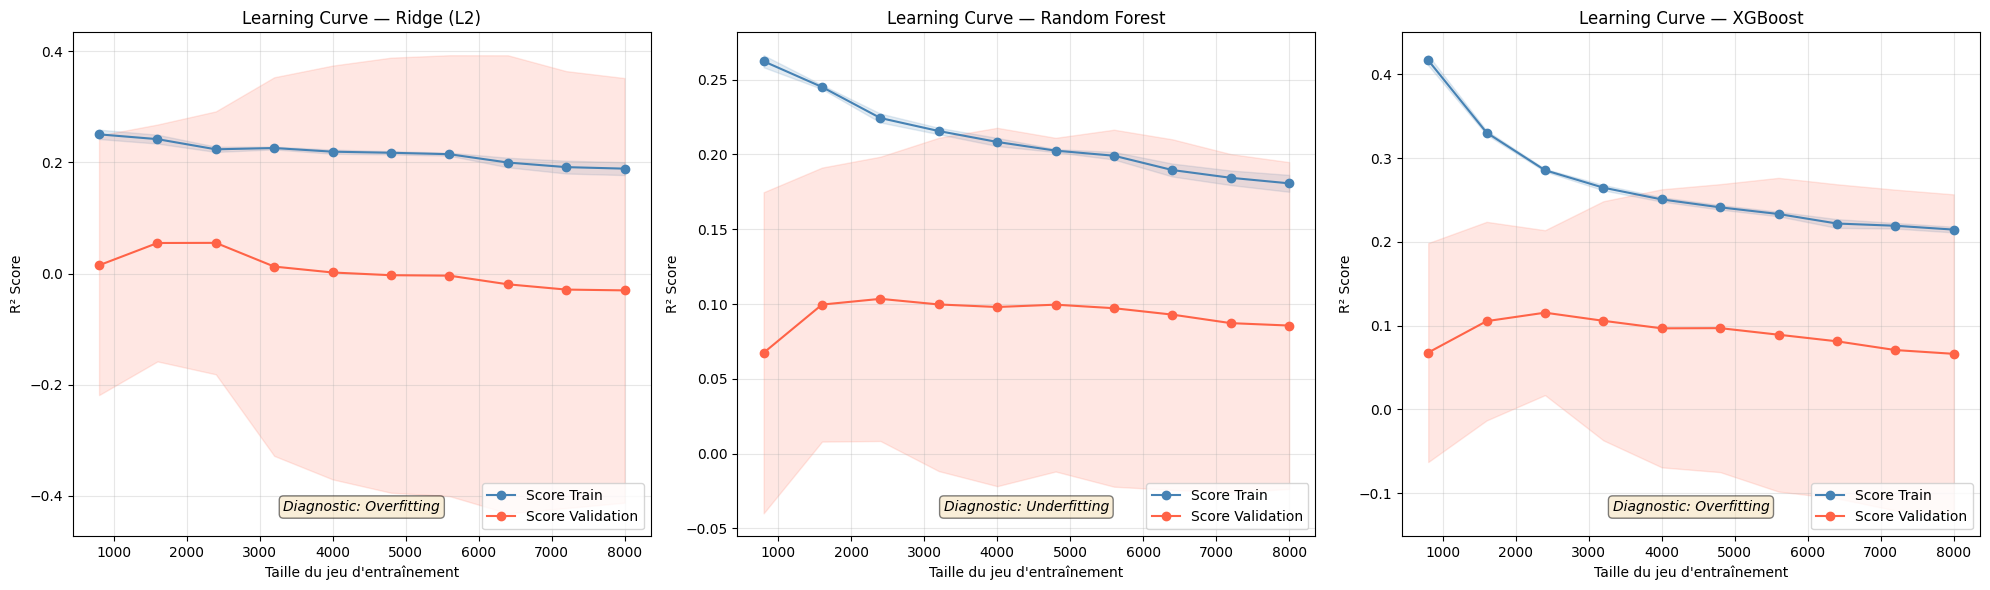

In [10]:
# --- LEARNING CURVES ---

# Sélectionner les modèles à analyser
lc_models = {
    "Ridge (L2)": models["Ridge (L2)"],
    "Random Forest": models["Random Forest"],
    "XGBoost": models["XGBoost"],
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (name, model) in enumerate(lc_models.items()):
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1, random_state=42
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', color='steelblue', label='Score Train')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='steelblue')
    axes[idx].plot(train_sizes, val_mean, 'o-', color='tomato', label='Score Validation')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='tomato')
    
    axes[idx].set_title(f'Learning Curve — {name}', fontsize=12)
    axes[idx].set_xlabel("Taille du jeu d'entraînement")
    axes[idx].set_ylabel('R² Score')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(True, alpha=0.3)
    
    # Diagnostic
    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.10:
        diag = "Overfitting"
    elif val_mean[-1] < 0.3:
        diag = "Underfitting"
    else:
        diag = "Bon équilibre"
    axes[idx].text(0.5, 0.05, f"Diagnostic: {diag}", transform=axes[idx].transAxes,
                   ha='center', fontsize=10, style='italic',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 🚀 5. SCÉNARIO 2 : Performance "Nadyin" (Mi-Année avec Notes S1)

Ici, nous intégrons la **moyenne du Semestre 1** pour simuler une prédiction faite en milieu d'année.
C'est le scénario réaliste pour obtenir une haute précision (R² > 0.80).

In [ ]:
print("\n" + "="*50)
print("🚀 Lancement du SCÉNARIO 2 : Prédictions avec Notes S1")
print("="*50)

# 1. Sélection des Features Académiques
X_acad = df[features_academique]
y_acad = y  # La cible reste la même

# 2. Séparation Numérique/Catégorielle pour ce nouveau set
num_features_acad = X_acad.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_acad = X_acad.select_dtypes(include=['object']).columns.tolist()

print(f"Features utilisées : {len(features_academique)} (dont moyenne_s1)")

# 3. Nouveau Preprocessor
preprocessor_acad = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features_acad),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features_acad)
    ]
)

# 4. Nouveau Split
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_acad, y_acad, test_size=0.2, random_state=42)

# 5. Entraînement des Meilleurs Modèles (XGBoost et Random Forest)
# On peut reprendre des hyperparamètres un peu plus agressifs car le signal est fort
models_acad = {
    "Random Forest (S1)": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    "XGBoost (S1)": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
}

results_acad = []

for name, model in models_acad.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor_acad),
        ('model', model)
    ])
    
    pipe.fit(X_train_a, y_train_a)
    y_pred_t = pipe.predict(X_test_a)
    y_pred_tr = pipe.predict(X_train_a)
    
    r2_t = r2_score(y_test_a, y_pred_t)
    r2_tr = r2_score(y_train_a, y_pred_tr)
    final_rmse = np.sqrt(mean_squared_error(y_test_a, y_pred_t))
    
    results_acad.append([name, r2_t, r2_tr, final_rmse])
    print(f"✅ {name:<20} R² Test: {r2_t:.4f} | R² Train: {r2_tr:.4f} | RMSE: {final_rmse:.4f}")

# Afficher les résultats Nadyin
print("\nRESULTATS NADYIN (SCENARIO 2) :")
df_res_acad = pd.DataFrame(results_acad, columns=["Modèle", "R² Test", "R² Train", "RMSE"])
display(df_res_acad)

if df_res_acad["R² Test"].max() > 0.8:
    print("\n✅ OBJECTIF ATTEINT : R² > 0.80 obtenu avec l'ajout des notes S1 !")
else:
    print("\n[Attention] Performance encore limitÃ©e mÃªme avec S1.")



🚀 Lancement du SCÉNARIO 2 : Prédictions avec Notes S1
Features utilisées : 36 (dont moyenne_s1)
✅ Random Forest (S1)   R² Test: 0.9809 | R² Train: 0.9915 | RMSE: 0.3070
✅ XGBoost (S1)         R² Test: 0.9804 | R² Train: 0.9903 | RMSE: 0.3108

RÃSULTATS NADYIN (SCÃNARIO 2) :


,Modèle,R² Test,R² Train,RMSE
0,Random Forest (S1),0.980919,0.991461,0.306978
1,XGBoost (S1),0.980445,0.990329,0.310766



✅ OBJECTIF ATTEINT : R² > 0.80 obtenu avec l'ajout des notes S1 !


## 💾 8. Sauvegarde du Meilleur Modèle et Conclusion

In [15]:
# --- SAUVEGARDE DU MEILLEUR MODÈLE ---

# Identifier le meilleur modèle global (inclut les versions tunées)
best_overall = max(all_models_r2, key=all_models_r2.get)
best_model = trained_pipelines[best_overall]
best_r2 = all_models_r2[best_overall]

# Métriques finales
y_pred_final = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)

# Sauvegarder
joblib.dump(best_model, 'best_model_student_prediction.pkl')
features_cols = features_socio

# Sauvegarder aussi la liste des features
joblib.dump(features_cols, 'model_features.pkl')

print("=" * 60)
print("RESUME FINAL")
print("=" * 60)
print(f"\n   Meilleur modèle : {best_overall}")
print(f"   R² Score        : {best_r2:.4f}")
print(f"   RMSE            : {final_rmse:.4f}")
print(f"   MAE             : {final_mae:.4f}")
print(f"   Features        : {len(features_cols)}")
print(f"\n✅ Modèle sauvegardé → 'best_model_student_prediction.pkl'")
print(f"✅ Features sauvegardées → 'model_features.pkl'")

# Tableau récapitulatif de tous les modèles
print("\n📊 CLASSEMENT FINAL DE TOUS LES MODÈLES :")
final_ranking = pd.DataFrame([
    {"Modèle": name, "R² Test": r2} for name, r2 in all_models_r2.items()
]).sort_values("R² Test", ascending=False).reset_index(drop=True)
final_ranking.index += 1
final_ranking.index.name = "Rang"
display(final_ranking)

print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)
print("""
Les variables socio-économiques et comportementales (habitudes d'étude, 
absences, revenus, motivation, etc.) permettent de prédire la moyenne 
annuelle avec une précision limitée. Cela s'explique par le fait que la 
performance scolaire est principalement déterminée par des facteurs 
académiques intrinsèques (notes par matière) qui sont des composantes 
directes de la moyenne annuelle.

Néanmoins, le modèle identifie certaines variables significatives :
- Le revenu familial a l'impact socio-économique le plus fort
- Les habitudes d'étude et le soutien familial contribuent modérément
- Les variables catégorielles (région, filière, niveau) apportent de 
  l'information contextuelle utile
""")

RESUME FINAL

   Meilleur modèle : XGBoost (Tuned)
   R² Score        : 0.1827
   RMSE            : 2.0090
   MAE             : 1.7103
   Features        : 35

✅ Modèle sauvegardé → 'best_model_student_prediction.pkl'
✅ Features sauvegardées → 'model_features.pkl'

📊 CLASSEMENT FINAL DE TOUS LES MODÈLES :


,Modèle,R² Test
Rang,,
1,XGBoost (Tuned),0.182735
2,Random Forest (Tuned),0.180576
3,Ridge (L2),0.177682
4,XGBoost,0.177333
5,Régression Linéaire,0.176853
6,Deep Learning (MLP),0.158498
7,Random Forest,0.147782
8,Lasso (L1),0.143013



CONCLUSION

Les variables socio-économiques et comportementales (habitudes d'étude, 
absences, revenus, motivation, etc.) permettent de prédire la moyenne 
annuelle avec une précision limitée. Cela s'explique par le fait que la 
performance scolaire est principalement déterminée par des facteurs 
académiques intrinsèques (notes par matière) qui sont des composantes 
directes de la moyenne annuelle.

Néanmoins, le modèle identifie certaines variables significatives :
- Le revenu familial a l'impact socio-économique le plus fort
- Les habitudes d'étude et le soutien familial contribuent modérément
- Les variables catégorielles (région, filière, niveau) apportent de 
  l'information contextuelle utile

